# Text summarization using machine learning techniques

## A sequence-to-sequence model using an Encoder-Decoder with Attention

The encoder-decoder model for recurrent neural networks is an architecture for sequence-to-sequence prediction problems. It comprised two parts:
-	**Encoder**: The encoder is responsible for stepping through the input time steps, read the input words one by one and encoding the entire sequence into a fixed length vector called a context vector.
-	**Decoder**: The decoder is responsible for stepping through the output time steps while reading from the context vector, extracting the words one by one.
The trouble with seq2seq is that the only information that the decoder receives from the encoder is the last encoder hidden state which is like a numerical summary of an input sequence. So, for a long input text, we expect the decoder to use just this one vector representation to output a translation. This might lead to catastrophic forgetting.

To solve this problem, the attention mechanism was developed. **Attention** is proposed as a method to both align and translate. It identifies which parts of the input sequence are relevant to each word in the output (alignment) and use that relevant information to select the right output (translation). So instead of encoding the input sequence into a single fixed context vector (reason for the mentioned bad performance), the attention model develops a context vector that is filtered specifically for each output time step [11]. Attention provides the decoder with information from every encoder hidden state. With this setting, the model can selectively focus on useful parts of the input sequence and hence, learn the alignment between them.

In the next few sections we will go through the whole process: Load the datasets and vector representation, build the vocabulary, define the encoder, decoder and attention mechanism. Then we will code the train stage, iterating over the datasets, and finally we will make the predictions for the validation dataset to get the value of the metrics of interest.



### Importing the libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

#Import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.switch_backend('agg')
import matplotlib.ticker as ticker

#Import libraries for text processing
#from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re

stop_words = stopwords.words('english')

#Import some utils
from io import open
import unicodedata
import random
import pickle

#Import the pytorch libraries and modules
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


Install and import the library to calculate the evaluations metrics: ROUGE

In [2]:
!pip install rouge
#Import library to calculate the evaluation metric
from rouge import Rouge

Set parameters with the train and validation filenames

In [7]:
data_path = '/kaggle/input/cleaned-news-summary/cl_train_news_summary_more.csv'
valid_path = '/kaggle/input/cleaned-news-summary/cl_valid_news_summary_more.csv'

### Loading the train and validation datasets

We are reading just a subset of 10,000 rows from the validation datasets to reduce the runnig time.

In [8]:
# Read the csv file
data = pd.read_csv(data_path,encoding='utf-8')
#Drop rows with duplicate values in the text column
data.drop_duplicates(subset=["text"],inplace=True)
#Drop rows with null values in the text variable
data.dropna(inplace=True)
data.reset_index(drop=True,inplace=True)
# we are using the text variable as the summary and the ctext as the source text
print('Drop null and duplicates, Total rows:', len(data))
# Rename the columns
data.columns = ['summary','text']
data.head()

Drop null and duplicates, Total rows: 83589


,summary,text
0,paytm raises 1 4 billion softbank largest funding,digital payments startup paytm raised 1 4 bill...
1,petrol price cut â per litre daily revision st...,oil companies thursday reduced petrol price â ...
2,army plans deploy women officers cyber warfare,indian army announced plans deploy women offic...
3,uday chopra confirms yrf produce jessica chast...,yash raj films ceo uday chopra confirmed los a...
4,mulayam yadav contest 2019 polls mainpuri sp l...,senior samajwadi party leader ram gopal yadav ...


In [9]:
# Read the csv file
valid_dataset = pd.read_csv(valid_path,encoding='utf-8', nrows=10000)
#Drop rows with duplicate values in the text column
valid_dataset.drop_duplicates(subset=["text"],inplace=True)
#Drop rows with null values in the text variable
valid_dataset.dropna(inplace=True)
valid_dataset.reset_index(drop=True,inplace=True)
# we are using the text variable as the summary and the ctext as the source text
print('Drop null and duplicates, Total rows:', len(valid_dataset))
# Rename the columns
valid_dataset.columns = ['summary','text']
valid_dataset.head()

Drop null and duplicates, Total rows: 10000


,summary,text
0,govt forms sit ryan murder case cbse seeks saf...,hrd ministry formed threemember special invest...
1,indrani asks furniture jewellery divorce report,letter written jail sheena bora murder accused...
2,ed raids 35 premises nirav modi â assets seized,enforcement directorate ed friday conducted se...
3,japan admits 1st death 2011 fukushima nuclear ...,japan acknowledged first time worker died radi...
4,entire village germany auctioned,entire village germany auctioned weekend bids ...


## Cleaning the data

We create a mapping from common contractions to it expanded form, we will use it later to clean and process the texts.

In [10]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

Function to preprocess the data (but it could be processed previously)

In [11]:
def preprocess(text):
    ''' Function to clean the input text: convert to lowercase, expand the contractions, remove the stopwords,
        remove punctuations
    '''

    text = text.lower() # lowercase
    text = text.split() # convert have'nt -> have not
    
    for i in range(len(text)): # For every token or word in the text
        word = text[i]
        if word in contraction_mapping:
            text[i] = contraction_mapping[word] # Expand the contractions
            
    text = " ".join(text) # Rejoin the word to a sentence
    text = text.split() # Split the text into words
    newtext = []
    for word in text: # For every token or word in the text
        if word not in stop_words:
            newtext.append(word) #Include only the non stopwords
    text = " ".join(newtext)
    text = text.replace("'s",'') # Expand contractions, convert your's -> your
    text = re.sub(r'\(.*\)','',text) # remove (words)
    text = re.sub(r'[^a-zA-Z0-9. ]','',text) # remove punctuations
    text = re.sub(r'\.',' . ',text)
    return text


Apply the cleaning and preprocess function to remove symbols, especial characters, stopwords,.. on the training and validation datasets

In [12]:
data['summary'] = data['summary'].apply(lambda x:preprocess(x))
data['text'] = data['text'].apply(lambda x:preprocess(x))

In [13]:
valid_dataset['summary'] = data['summary'].apply(lambda x:preprocess(x))
valid_dataset['text'] = data['text'].apply(lambda x:preprocess(x))

Show a example of the cleaned text and summary:

In [14]:
data['summary'][20]
data['text'][20]

'tamil nadu government claimed reports plastic rice sold state spread panic among people fake comes food safety department carried inspections 50 shops district tanjore ensure incidents plastic rice'

Next, we split our pandas dataframe to two variables, x and y, for training 

In [15]:
x = data['text']
y = data['summary']
print(x[50],y[50],sep='\n')

tony chapron french referee kicked footballer sending ligue 1 game handed threemonth ban three months suspended ban ligue 1 chapron apologised actions following day incident called reaction clumsy inappropriate
french referee kicked footballer banned 3 months


Set a global variable to indicate if there is a GPU available for training

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Define and create the vocabularies

Now we create a Vocab (vocabulary) Class to store the vocabulary, the mapping between words and its numeric representation and functions to add words and sentences to the vocabulary. There is also some function to transform a sentence to its vector representation and to transform the representation to a Torch tensor.

In [17]:
SOS_token = 0
EOS_token = 1


class Vocab:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        ''' Add every word in a sentence to the vocabulary '''
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        ''' Add a word to the vocabulary'''
        if word not in self.word2index:
            #Include the word in the mapping from word to index
            self.word2index[word] = self.n_words
            #Set the count of ocurrencies of the word to 1
            self.word2count[word] = 1
            # Include the word in the indexes
            self.index2word[self.n_words] = word
            # Increment by 1 the number of words
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
    def save_to_file(self, filename):
        ''' Save the Vocab object to a file'''
        with open(filename,'wb') as f:
            pickle.dump(self,f) 

def load_vocab(filename):
    ''' Load a Vocab instance from a file'''
    with open(filename,'rb') as f:
        v = pickle.load(f)
    return v

def read_vocabs(text, summary, reverse=False):
    print("Reading lines...")
    
    # Split every line into pairs and normalize
    pairs = [[text[i],summary[i]] for i in range(len(text))]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Vocab(summary)
        output_lang = Vocab(text)
    else:
        input_lang = Vocab(text)
        output_lang = Vocab(summary)

    return input_lang, output_lang, pairs

def prepare_data(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = read_vocabs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

Now, we need to build a vocabulary for each dataset, training and validation.

In [18]:
# Create the vocabularies of the inout and output data and return the data in pairs of (source text, summary)
input_lang, output_lang, pairs = prepare_data( x, y , False)
print(random.choice(pairs))

Reading lines...
Read 83589 sentence pairs
Counting words...
Counted words:
0        digital payments startup paytm raised 1 4 bill...
1        oil companies thursday reduced petrol price  d...
2        indian army announced plans deploy women offic...
3        yash raj films ceo uday chopra confirmed los a...
4        senior samajwadi party leader ram gopal yadav ...
                               ...                        
83584    north korea estimated 60 nuclear weapons south...
83585    former west indies captain sir viv richards 18...
83586    malikaa marathe 13yearold national tennis cham...
83587    usbased software supplier ebixs indian subsidi...
83588    exaustralia cricketer dean jones said playing ...
Name: text, Length: 83589, dtype: object 95677
0        paytm raises 1 4 billion softbank largest funding
1        petrol price cut  per litre daily revision starts
2           army plans deploy women officers cyber warfare
3        uday chopra confirms yrf produce jessica c

An important parameter we need to set is the maximum length of a sequence of text. We find out the max length in the sourfe texts and the summaries and set the max length to that value plus one.

In [19]:
len_x_tr=[]
len_y_tr=[]
# For every pair Text, summary on the training dataset
for i in pairs:
    len_x_tr.append(len(i[0].split(' '))) # Get the count of words for the soure text
    len_y_tr.append(len(i[1].split(' '))) # Get the count of words for the summary
    
# 
x_test = valid_dataset['text'].values
y_test = valid_dataset['summary'].values

len_x_val=[]
len_y_val=[]
# For every pair Text, summary
for i in range(len(x_test)):
    len_x_val.append(len(x_test[i].split(' '))) # Get the count of words for the soure text
    len_y_val.append(len(y_test[i].split(' '))) # Get the count of words for the summary

print('Max Length of Texts: ', max(len_x_tr), 'Max Length of Summaries: ',max(len_x_val))
# Set the global variable MAX LENGTH
MAX_LENGTH = max(max(len_x_tr), max(len_y_tr), max(len_x_val), max(len_y_val), )+1
print(MAX_LENGTH)

Max Length of Texts:  60 Max Length of Summaries:  53
61


## Create the model

First, we define the Encoder component of our Sequence-to-Sequence model. It will be comprised by an embedding layer and a GRU layer (Gate Recurrent Unit).

In [20]:
class EncoderRNN(nn.Module):
    ''' Define an encoder in a seq2seq architecture'''
    def __init__(self, input_size, hidden_size):
        ''' Initialize tyhe encoder instance defining its parameters:
            Input:
                - input_size: the size of the vocabulary
                - hidden:size: size of the hidden layer
        '''
        super(EncoderRNN, self).__init__()
        # Set the hidden size
        self.hidden_size = hidden_size
        # Create the embedding layer of size (vocabulary length, hidden_size) 
        self.embedding = nn.Embedding(input_size, hidden_size)
        # Create a GRU layer
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        ''' Run a Forward pass of the encoder to return outputs
            Input:
                Input: a tensor element (integer) representing the next word in the sentence
                hidden: a tensor, the previous hidden state of the encoder
        '''
        # Get the embedding of the input
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        
        # Apply a forward step of the GRU returning the output features and
        # the hidden state of the actual time step
        output, hidden = self.gru(output, hidden)
        
        return output, hidden

    def initHidden(self):
        ''' Initialize the hidden state of the encoder, tensor of zeros'''
        return torch.zeros(1, 1, self.hidden_size, device=device)

Next, create the decoder with attention component

In [21]:
class AttnDecoderRNN(nn.Module):
    ''' Define a decoder with atention in a seq2seq architecture'''
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        ''' Initialize the decoder instance defining its parameters:
            Input:
                - hidden_size:size: size of the hidden layer (Hyperparameter)
                - output_size: the size of the vocabulary of the output summary
                - dropout_p: dropout probability to apply
                - max_length: max length (number of words) of an output or summary
        '''

        super(AttnDecoderRNN, self).__init__()
        # Set parameters of the decoder
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        #Create an embedding layer for the input (output vocabulary, hidden size)
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        # Create some linear layers to build the attention mechanism
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        # A dropout layer
        self.dropout = nn.Dropout(self.dropout_p)
        # A GRU layer
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        # A Fully-connected layer
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        ''' Run a Forward pass of the decoder to return outputs
            Input:
                Input: a tensor element (integer) representing the previous output of the decoder
                hidden: a tensor, the previous hidden state of the decoder
                Encoder outputs: a tensor, outputs of the encoder
        '''
        
        #Get the embedding representation of the input
        embedded = self.embedding(input).view(1, 1, -1)
        # Apply dropout 
        embedded = self.dropout(embedded)
        #Calculate the attention weights of the attention mechanism using the encoder states
        #in previous time steps
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        
        #Calculate the context vectors fo the attention mechanism using the attention weights
        # and the encoder outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        
        # Apply a forward pass to the GRU layer of the decider using the output from the attention
        # as input and the hidden state
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        # return the output features, the hidden state and the attention weights
        return output, hidden, attn_weights

    def initHidden(self):
        ''' Initialize the hidden state of the encoder, tensor of zeros'''
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Define the steps of the training process

First, we create functions to help us to handle and transform the text input data to tensor datatype requiered to train

In [22]:
def indexesFromSentence(lang, sentence):
    ''' Transform a sentence in string format to a list of indexes or integers.
            The model need to be feeded with numbers, not characters
            Input:
                - sentence: a string
            Output:
                - a list of integers, the representation of the sentence in the vector space.
    '''
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    ''' Transform a sentence in string format to tensor of indexes or integers.
            Out pytorch model work with tensor objects
            Input:
                - sentence: a string
            Output:
                - a tensor of integers, the representation of the sentence in the vector space.
    '''
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    ''' Convert a pair of text data (source text, summary) to tensors
        Input:
        - pair: tuple of strings, the source text and its summary
        Output:
        - tuple of tensors, the input tensor and the outout one
    '''
    # Convert the source text to the input tensor
    input_tensor = tensorFromSentence(input_lang, pair[0])
    # Convert the summary to the output tensor
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

We will apply Teacher forcing, a method for quickly and efficiently training recurrent neural network models that use the ground truth from a prior time step as input, that is, using the actual or expected output from the training dataset at the current time step y(t) as input in the next time step X(t+1), rather than the output generated by the network 

First we define the probability of applying teacher forcing.

In [23]:
teacher_forcing_ratio = 0.5

This function execute a training step where we provide an input and target tensor and apply the algorithm on it. 

In [24]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    ''' Run all the steps in the training phase of a batch of examples
        Input:
        - input_tensor: a tensor, vector representation of the input text
        - target_tensor: a tensor, vector representation of the expect or labelled output or summary
        - encoder: a Class Encoder object, the encoder
        - decoder: a Class AttnDecoder object, the decoder
        - encoder_optimizer: a torch optimizer, the optimizer of the encoder
        - decoer_optimizer: a torch optimizer, the optimizer of the decoder
        - criterion: a pytoch loss function
        - max_length: an integer, maximun length of an output
    '''
    #Init the encoder hidden state
    encoder_hidden = encoder.initHidden()
    
    # Reset the optimizer
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    # Set the length if the source text and the summary
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    # Create the initial encoder output, all zeros
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    # For every token in the source text or inout
    for ei in range(input_length):
        # Forward pass of the encoder to get the encoder output and hidden state
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
        
    # Set the initial decoder input as the SOS token
    decoder_input = torch.tensor([[SOS_token]], device=device)
    #Set the initial decoder hidden state equals to the last encoder hidden state
    decoder_hidden = encoder_hidden

    # Active teacher forcing with probability teacher_forcing_ratio 
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            # Forward pass of the decoder returning the decoder output, hidden state and context vector
            # of the attention mechanism
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # Increment the loss function by the loss of the decoder output in the actual time step
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            # Forward pass of the decoder returning the decoder output, hidden state and context vector
            # of the attention mechanism
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
             # Select the decoder output with the highest probability
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            # Increment the loss function by the loss of the decoder output in the actual time step
            loss += criterion(decoder_output, target_tensor[di])
            # Stop training if the EOS token is returned
            if decoder_input.item() == EOS_token:
                break
   # Apply the backward pass to calculate and propagate the loss
    loss.backward()
    # Apply a step of the optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    # Return the final loss
    return loss.item() / target_length

Some helpers function to show the progress and losses during training

In [25]:
import time
import math


def asMinutes(s):
    ''' Return the seconds, s, to a string in the format: Xm Ys'''
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    ''' Return '''
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def showPlot(points):
    ''' Plot the points in a line graph to show a training metric'''
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

The next function describes the training process, iterating over the number of epochs

In [26]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    ''' Train a encoder-decoder model on the input x for n_iters iterations
        Input:
        - encoder: a Class Encoder object, the encoder
        - decoder: a Class AttnDecoder object, the decoder
        - x: array of strings, source texts of the training dataset
        - y: array of strings, target texts or summaries of the training dataset
        - vocab_input: a Vocab Class object, vocabulary of the source texts
        - vocab_output: a Vocab Class object, vocabulary of the target texts
        - n_iters: integer, number of iterations
        - print_every: integer, print the progress every print_every iteration
        - plot_every: integer, plot the losses every plot_every iteration
        - learning_rate: float, learning rate
    '''

    print("Training....")
    # Get the current time
    start = time.time()
    # Initialize variables for progress tracking
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    # Create the optimizer for the encoder and the decoder
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    # Extract the training set randomly for all the iterations
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    # Set the function loss to apply
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        if iter% 1000 == 0:
            print(iter,"/",n_iters + 1) # Plot progress
            
        # Get the next pair of source text and target to train on
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        # Train on the pair of data selected
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        # Set the variable to plot the progress
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            # Print the ETA and current loss
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            # Plot the current loss
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Evaluate or predict function

In [27]:
def predict(encoder, decoder, sentence, input_lang, output_lang, max_length=MAX_LENGTH):
    ''' Function to predict the summary of the source text sentence with a max length
        Input:
        - encoder: a Class Encoder object, the encoder
        - decoder: a Class AttnDecoder object, the decoder
        - vocab_input: a Vocab Class object, vocabulary of the source texts
        - vocab_output: a Vocab Class object, vocabulary of the target texts
        - sentence: string, source text to predict

    '''
    with torch.no_grad():
        # Get the tensor of the source text
        input_tensor = tensorFromSentence(input_lang, sentence)
        # Calculate the length of the source text
        input_length = input_tensor.size()[0]
        # Set the initial hidden state of the encoder
        encoder_hidden = encoder.initHidden()
        # Set the initial encoder outputs
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        # For every word in the input
        for ei in range(input_length):
            # Forward pass of the encoder
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        # Set the initial input of the decoder 
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        # Set the initial hidden state of the decoder to the hidden state of the decoder in the last time step
        decoder_hidden = encoder_hidden

        decoded_words = []
        # Set the initial context vectors of the decoder to zeros
        decoder_attentions = torch.zeros(max_length, max_length)
        # For every word or step in the output sequence
        for di in range(max_length):
            # Forward pass of the decoder
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # Save the decoder attention vector of the step
            decoder_attentions[di] = decoder_attention.data
            # Get the element in the decoder output with the highest probability (the best output)
            topv, topi = decoder_output.data.topk(1)
            # If the token returned is EOS then finish
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                # Append the token in the summary returned by the decoder
                decoded_words.append(output_lang.index2word[topi.item()])
            # Set the decoder input to the output selected
            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

The next function will generate the predictions for a set of source texts to be evaluated

In [28]:
def generate_predictions(x_test, encoder, decoder, input_vocab, output_vocab, max_length, print_every=20):
    ''' Generate the predicted summaries of the source texts on x_test
        Input:
        - x_test: list of strings, the source texts
        - encoder: a Class Encoder object, the encoder
        - decoder: a Class AttnDecoder object, the decoder
        - input_vocab: a Vocab Class object, vocabulary of the source texts
        - output_vocab: a Vocab Class object, vocabulary of the target texts
        - max_length: integer, max length of the output summary
        - print_every: integer, print progress every print_every iterations
    '''
    predicted_summaries = []
    # Set a progress bar
    #kbar = pkbar.Kbar(target=len(x_test), width=8)
    # Para cada text or document in the validation dataset
    for i,doc in enumerate(x_test):
        # Predict the summary for the document
        #pred_summ = predict(doc,vocab,params,batch_size=1)
        pred_summ,_ = predict(encoder, decoder, doc, input_vocab, output_vocab, max_length)
        predicted_summaries.append(' '.join(pred_summ[:-1]))
        #predicted_summaries.append(' '.join(pred_summ))
        
        #if i%print_every==0:
        #    kbar.update(i)
            
    # Set teh labeled summaries as the y_test variable, column summary of our dataset
    return predicted_summaries


In [29]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = predict(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Training the model

It is time to train our model, setting the hidden size in 100, the iterations in 150000

Training....
1000 / 75001
2000 / 75001
3000 / 75001
4000 / 75001
5000 / 75001
3m 26s (- 48m 4s) (5000 6%) 7.0141
6000 / 75001
7000 / 75001
8000 / 75001
9000 / 75001
10000 / 75001
6m 51s (- 44m 33s) (10000 13%) 7.1869
11000 / 75001
12000 / 75001
13000 / 75001
14000 / 75001
15000 / 75001
10m 13s (- 40m 55s) (15000 20%) 7.0727
16000 / 75001
17000 / 75001
18000 / 75001
19000 / 75001
20000 / 75001
13m 38s (- 37m 31s) (20000 26%) 7.0824
21000 / 75001
22000 / 75001
23000 / 75001
24000 / 75001
25000 / 75001
17m 2s (- 34m 4s) (25000 33%) 7.0924
26000 / 75001
27000 / 75001
28000 / 75001
29000 / 75001
30000 / 75001
20m 25s (- 30m 37s) (30000 40%) 7.0620
31000 / 75001
32000 / 75001
33000 / 75001
34000 / 75001
35000 / 75001
23m 48s (- 27m 12s) (35000 46%) 6.9544
36000 / 75001
37000 / 75001
38000 / 75001
39000 / 75001
40000 / 75001
27m 11s (- 23m 47s) (40000 53%) 7.0051
41000 / 75001
42000 / 75001
43000 / 75001
44000 / 75001
45000 / 75001
30m 36s (- 20m 24s) (45000 60%) 6.9072
46000 / 75001
47000 / 

<Figure size 432x288 with 0 Axes>

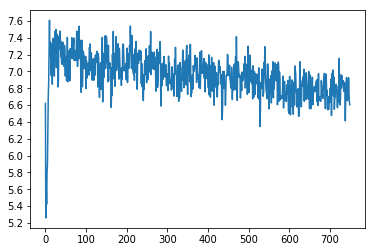

In [39]:
hidden_size = 100
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.2).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

Once the model is trained we will save it, we can use it in the future to make predictions. We need to save the encoder, the decoder and the input and output vocabularies.

In [40]:
torch.save(encoder1.state_dict(), './enc.w')
torch.save(attn_decoder1.state_dict(), './att.w')
# Save the vocabularies
input_lang.save_to_file('input_vocab.pkl')
output_lang.save_to_file('output_vocab.pkl')

In [41]:
# Load the vocabularies, 
#input_vocab= load_vocab('input_vocab.pkl')
#output_vocab= load_vocab('output_vocab.pkl')

In [42]:
# Uncomment and execute if you want to show some results quickly
#evaluateRandomly(encoder1, attn_decoder1)

## Evaluate the model

We predict the summary for every text in our validation dataset and then we can compare them to the targeted summary. We also calculate the Rouge metrics and visualize the results

In [43]:
x_test = valid_dataset['text'].values
y_test = valid_dataset['summary'].values
# Generate the predctions on the validation dataset
predicted_summaries = generate_predictions(x_test, encoder1, attn_decoder1, input_lang, output_lang, MAX_LENGTH, 100)
# Set teh labeled summaries as the y_test variable, column summary of our dataset
labeled_summaries = y_test
#print(len(x_test), len(labeled_summaries), len(predicted_summaries))

Show some results

In [44]:
print('\n Pred: ',predicted_summaries[100],'\n Target: ', labeled_summaries[100])
print('\n Pred: ',predicted_summaries[200],'\n Target: ', labeled_summaries[200])
print('\n Pred: ',predicted_summaries[300],'\n Target: ', labeled_summaries[300])
print('\n Pred: ',predicted_summaries[400],'\n Target: ', labeled_summaries[400])
print('\n Pred: ',predicted_summaries[500],'\n Target: ', labeled_summaries[500])


 Pred:  man man found found found 
 Target:  mika singh daler mehndis elder brother amarjeet passes away

 Pred:  man man found dead 
 Target:  sunfeast farmlite made aashirvaad atta 0 maida

 Pred:  man kapoor shares pic 
 Target:  take tremendous pride woman colour priyanka

 Pred:  delhi police arrested delhi delhi 
 Target:  swine flu toll rises 17 odisha

 Pred:  india bans pak pak pak 
 Target:  rafale aircraft capable waiting iaf vice chief


Lets evaluate with the ROUGE metric

In [45]:
def save_textfile(filename, strings):
    ''' Save the contect of a list of strings to a file called filename
    
        Input:
           - filename: name of the file to save the strings
           - strings: a list of string to save to disk
    '''
    
    with open(filename, 'w') as f:
        for item in strings:
            #Remove any \n in the string
            item = remove_CTL(item)
            f.write("%s\n" % item)

def eval_metrics(preds, targets, avg=True):
    ''' Evaluate the ROUGE metrics ROUGE-2 and ROUGE-L for every pair predicted summary - target summary
    
        Input:
           - preds: list of strings, predicted summaries
           - targets: list of string, target summaries
        Output:
            - rouge2_f_metric: list of float, the Rouge-2 fscore for every predicted summary
            - rougel_f_metric: list of float, the Rouge-L fscore for every predicted summary
    '''
    #Lets calculate the rouge metrics for every document
    rouge = Rouge()
    scores = rouge.get_scores(preds, targets, avg)
    # Create the output variables
    if avg:
        rouge2_f_metric = scores['rouge-2']['f']
        rouge2_p_metric = scores['rouge-2']['p']
        rouge2_r_metric = scores['rouge-2']['r']
        rougel_f_metric = scores['rouge-l']['f']
        rougel_p_metric = scores['rouge-l']['p']
        rougel_r_metric = scores['rouge-l']['r']
    else:
        rouge2_f_metric = [score['rouge-2']['f'] for score in scores]
        rouge2_p_metric = [score['rouge-2']['p'] for score in scores]
        rouge2_r_metric = [score['rouge-2']['r'] for score in scores]
        rougel_f_metric = [score['rouge-l']['f'] for score in scores]
        rougel_p_metric = [score['rouge-l']['p'] for score in scores]
        rougel_r_metric = [score['rouge-l']['r'] for score in scores]

       
    
    return rouge2_f_metric, rouge2_p_metric, rouge2_r_metric, rougel_f_metric, rougel_p_metric, rougel_r_metric

Now, we can calculate the Rouge-2 and Rouge-L metrics for the validation dataset 

In [46]:
# Calculate the Rouge-2 and Rouge-L metrics for the validation dataset
r2_f, r2_p, r2_r, rl_f, rl_p, rl_r = eval_metrics(predicted_summaries, list(labeled_summaries), False)
print('Mean Rouge-2 FScore: ',np.mean(r2_f), 'Mean Rouge-L FScore: ',np.mean(rl_f))
#Store the results on the dataframe
valid_dataset['pred_summary'] = predicted_summaries
valid_dataset['rouge2-f'] = r2_f
valid_dataset['rouge2-p'] = r2_p
valid_dataset['rouge2-r'] = r2_r
valid_dataset['rougel-f'] = rl_f
valid_dataset['rougel-p'] = rl_p
valid_dataset['rougel-r'] = rl_r

Mean Rouge-2 FScore:  0.004118184491251278 Mean Rouge-L FScore:  0.06175245430535315


In [47]:
valid_dataset.to_csv('results.csv', index=False)
valid_dataset.head(5)

,summary,text,pred_summary,rouge2-f,rouge2-p,rouge2-r,rougel-f,rougel-p,rougel-r
0,paytm raises 1 4 billion softbank largest funding,digital payments startup paytm raised 1 4 bill...,startup startup startup raises raises raises,0.0,0.0,0.0,0.2,0.5,0.125
1,petrol price cut per litre daily revision starts,oil companies thursday reduced petrol price di...,india india india india india,0.0,0.0,0.0,0.0,0.0,0.000
2,army plans deploy women officers cyber warfare,indian army announced plans deploy women offic...,amazon killed 2 lakh,0.0,0.0,0.0,0.0,0.0,0.000
3,uday chopra confirms yrf produce jessica chast...,yash raj films ceo uday chopra confirmed los a...,new bans take new,0.0,0.0,0.0,0.0,0.0,0.000
4,mulayam yadav contest 2019 polls mainpuri sp l...,senior samajwadi party leader ram gopal yadav ...,bjp bjp bjp bjp bjp,0.0,0.0,0.0,0.0,0.0,0.000


## Visualizing the results

We are going to plotting the distribution of the Rouge-2 and Rouge-L values in the training and validation datasets

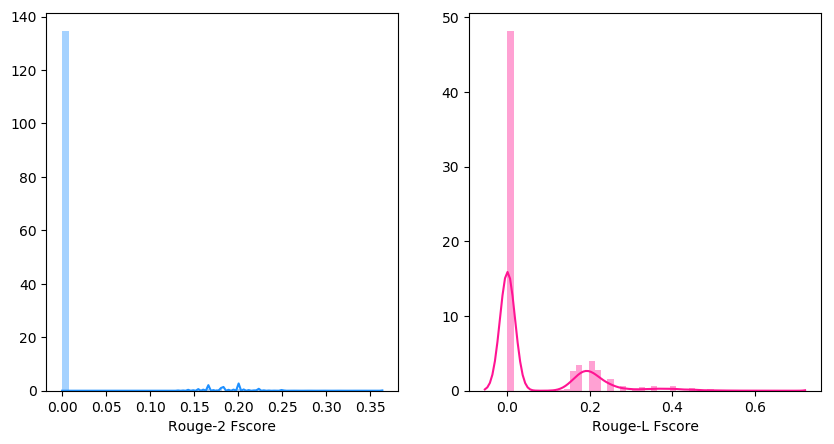

In [48]:
# Plot
kwargs = dict(hist_kws={'alpha':.7}, kde_kws={'linewidth':2})
# plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False, dpi=100)
sns.distplot(valid_dataset['rouge2-f'] , color="dodgerblue", ax=axes[0], axlabel='Rouge-2 Fscore')
sns.distplot(valid_dataset['rougel-f'], color="deeppink", ax=axes[1], axlabel='Rouge-L Fscore')